Pas de dataaugmentation
Pas de changement de lr
Dataset : Temps1, Temps2, Temps3

In [24]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob
from keras.applications import ResNet50

## Load model

In [25]:
model = Sequential()
model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=(224, 224, 3)))


In [26]:
model.add(ResNet50(weights='imagenet',
				   include_top=False,
				   classes=3, input_shape=(224,224,3)))

model.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
x = model.layers[-2].output
x = Flatten()(x)

In [28]:
x

<KerasTensor: shape=(None, 150528) dtype=float32 (created by layer 'flatten_1')>

In [29]:
x = Dense(units=128, activation='relu')(x)
output = Dense(units=3, activation='softmax')(x)

In [30]:
model = Model(inputs=model.input, outputs=output)

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1_input (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 19,268,099
Trainable params: 19,268,099
Non-trainable params: 0
_________________________________________________________________


## Load their data

In [32]:
# from PIL import Image
# import numpy as np
#
# def load_their(set):
#
#     xdata = []
#     ydata = []
#
#     file_list = glob.glob(
#         r"A:/F/%(set)s/*.png" % {"set": set})
#     for file in file_list:
#         classe = file[-6]
#         if classe not in ["0", "2", "5"]:
#             continue
#         classe = {"2": 1, "0": 0, "5": 2}[classe]
#         ydata.append(classe)
#         # im = imread(file)
#
#         image = Image.open(file)
#
#         im = image.resize((224, 224))
#         im = im.rotate(90, Image.NEAREST, expand = 1)
#
#         # Transformer l'image redimensionnée en un tableau NumPy
#         im = np.array(im)
#         im = im.reshape((224,224,1))
#         im = np.concatenate([im, im, im], axis=2)
#         xdata.append(im[:, :, :3])
#
#     return xdata, ydata
#
# from sklearn.model_selection import train_test_split
# xtrain, ytrain = load_their("train")
# xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1, random_state=42, shuffle=True)
# xtest, ytest = load_their("test")

## Load Data

In [33]:
from tqdm import tqdm
import random
def load(set: str):
    xtrain = []
    ytrain = []
    print(set)
    train_num_files = 0
    for source in ["Temps1", "Temps2", "Temps3"]:
        print(source)
        file_list = glob.glob(
            r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
        if source == "Temps0":
            file_list = random.choices(file_list, k=200)
        # print(len(file_list))
        for file in tqdm(file_list, desc="Loading..."):
            p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
            file_label = p + file[len(p):]
            file_label = file_label[:-4]
            file_label = file_label+'.txt'
            if os.path.isfile(file_label):
                f = open(file_label,"r+")
                a = f.read()
                if len(a)>=1:
                    im = imread(file)[:, :, :3]
                    train_num_files += 1
                    xtrain.append(im)
                    ytrain.append([int(a[0])])
                f.close()
    return xtrain, ytrain

xtrain, ytrain = load("train")
xval, yval = load("val")
xtest, ytest = load("test")
# xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

train
Temps1


Loading...: 100%|██████████| 519/519 [00:01<00:00, 493.72it/s]


Temps2


Loading...: 100%|██████████| 448/448 [00:01<00:00, 441.68it/s]


Temps3


Loading...: 100%|██████████| 326/326 [00:00<00:00, 408.59it/s]


val
Temps1


Loading...: 100%|██████████| 54/54 [00:00<00:00, 419.72it/s]


Temps2


Loading...: 100%|██████████| 310/310 [00:00<00:00, 423.47it/s]


Temps3


Loading...: 100%|██████████| 71/71 [00:00<00:00, 406.73it/s]


test
Temps1


Loading...: 100%|██████████| 31/31 [00:00<00:00, 345.27it/s]


Temps2


Loading...: 100%|██████████| 321/321 [00:00<00:00, 433.47it/s]


Temps3


Loading...: 100%|██████████| 181/181 [00:00<00:00, 397.97it/s]


In [34]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_f1_score',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [35]:
import tensorflow_addons as tfa

In [36]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(num_classes = 3, average = None, name = "f1_score")

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [38]:
from keras.utils import to_categorical

In [39]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)

In [40]:
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

## Data augmentation

In [41]:
from keras.preprocessing.image import ImageDataGenerator

datagen = []
factor = 0
datagen.append(ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # rotation_range=60*factor,
    # width_shift_range=0.2*factor,
    # height_shift_range=0.2*factor,
    # # brightness_range=(-1, 1),
    # zoom_range=(0.33*factor + (1-factor),1.3*factor + (1-factor)),
    horizontal_flip=True,
    # validation_split=0.1
))
random.seed(42)
datagen[0].fit(xtrain)

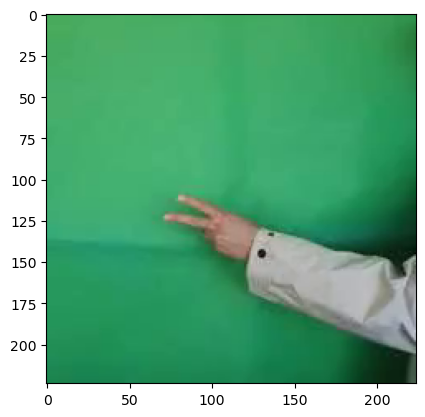

In [42]:
plt.imshow(datagen[-1].random_transform(xtrain[350], seed=42))

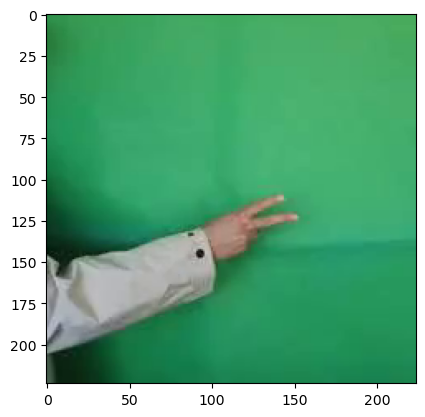

In [43]:
plt.imshow(xtrain[350])

In [44]:
import sys
sys.getsizeof(xtrain)

777326744

## Train

In [45]:
# metrics={"f1_score": [], "val_f1_score": []}

# for i in range(1):
#     # print("Introduction de variations : %(ii)d/10" % {"ii": i})
#     factor = 0
#
#     # K.set_value(model.optimizer.learning_rate, 0.0001*factor + 0.01*(1-factor))
#     for epochs in range(1):
history = model.fit(xtrain, ytrain,
      validation_data=(xval, yval),
      batch_size=10,
      # steps_per_epoch=len(xtrain) // 10,
      epochs=10, verbose=1)
#
# for k in metrics.keys():
#     metrics[k].extend(history.history[k])
# if history[-1].history["val_accuracy"][0] == 1:
#     break

Epoch 1/10
130/130 [==============================] - 2s 13ms/step - loss: 1937.6580 - accuracy: 0.4392 - f1_score: 0.2702 - val_loss: 1.0954 - val_accuracy: 0.3816 - val_f1_score: 0.1841
Epoch 2/10
130/130 [==============================] - 1s 10ms/step - loss: 1.0829 - accuracy: 0.4756 - f1_score: 0.2149 - val_loss: 1.0927 - val_accuracy: 0.3816 - val_f1_score: 0.1841
Epoch 3/10
130/130 [==============================] - 1s 10ms/step - loss: 1.0728 - accuracy: 0.4756 - f1_score: 0.2149 - val_loss: 1.0920 - val_accuracy: 0.3816 - val_f1_score: 0.1841
Epoch 4/10
130/130 [==============================] - 1s 10ms/step - loss: 1.0653 - accuracy: 0.4756 - f1_score: 0.2149 - val_loss: 1.0930 - val_accuracy: 0.3816 - val_f1_score: 0.1841
Epoch 5/10
130/130 [==============================] - 1s 10ms/step - loss: 1.0602 - accuracy: 0.4756 - f1_score: 0.2149 - val_loss: 1.0949 - val_accuracy: 0.3816 - val_f1_score: 0.1841
Epoch 6/10
130/130 [==============================] - 1s 10ms/step - los

On observe que le resnet n'arrive pas à comprendre les données dès lors qu'on introduit un peu de data augmentation, et ce même si on l'introduit progressivement.

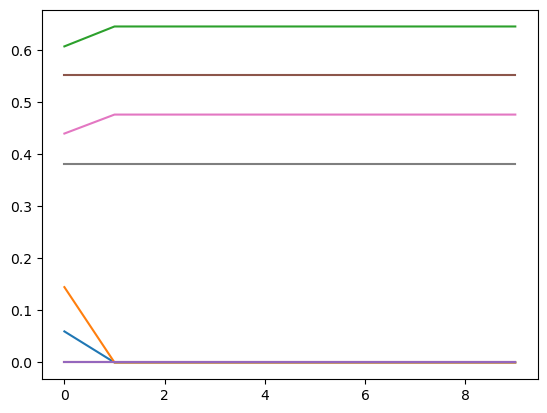

In [46]:
import matplotlib.pyplot as plt
#
# metrics={"f1_score": [], "val_f1_score": []}
# for h in history:
# 	for k in metrics.keys():
# 		metrics[k].extend(h.history[k])

plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [48]:
model.evaluate(xtest, ytest)

17/17 [==============================] - 0s 19ms/step - loss: 1.1278 - accuracy: 0.3527 - f1_score: 0.1738


[1.1277981996536255,
 0.3527204394340515,
 array([0.       , 0.       , 0.5214979], dtype=float32)]

In [ ]:
model.predict(xval)